In [ ]:
import pandas as pd
import torch
from torch import nn
import numpy
import matplotlib.pyplot as plt
import seaborn 
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Compose, Lambda
import random


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/deep_learning_hws/HWs/2/HW2_data/Q3_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/deep_learning_hws/HWs/2/HW2_data/Q3_test.csv')

### a) 

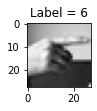

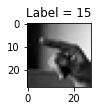

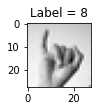

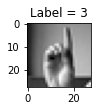

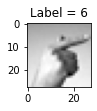

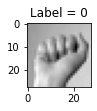

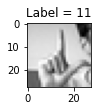

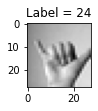

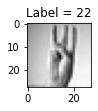

In [ ]:
randomlist = random.sample(range(0, len(train_df)), 9)
random_samples = train_df.loc[randomlist]
labels = list(random_samples['label'])
pixel_samples = random_samples.iloc[:,1:].to_numpy()

for i in range(9):  
  plt.subplot(330 + 1 + i)
  plt.title(f"Label = {labels[i]}")
  plt.imshow(pixel_samples[i].reshape((28, 28)), cmap=plt.get_cmap('gray'))
  plt.show()


### b) 

In [ ]:
validation_df = train_df.iloc[int(.8*len(train_df)):, :]

In [ ]:
import torch.nn as nn

# setting the device to cuda if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
class My_train_Dataset(Dataset):
  def __init__(self):
    self.X_train = train_df.iloc[:int(.8*len(train_df)), 1:].values
    self.Y_train = train_df.iloc[:int(.8*len(train_df)),0].values

    self.X_train = torch.tensor(self.X_train, dtype =torch.float32)
    self.Y_train = torch.tensor(self.Y_train)


    # self.X_train = torch.nn.functional.normalize(self.X_train)
    self.Y_train = torch.nn.functional.one_hot(self.Y_train, num_classes=25).type(torch.float32)

    self.X_train = self.X_train.to(device)
    self.Y_train = self.Y_train.to(device)
  def __len__(self):
    return len(self.X_train)
  
  def __getitem__(self, idx):
    return self.X_train[idx], self.Y_train[idx]

    

In [ ]:
class My_test_Dataset(Dataset):
  def __init__(self):
    self.X_test = test_df.iloc[:, 1:].values
    self.Y_test = test_df.iloc[:, 0].values

    self.X_test = torch.tensor(self.X_test, dtype =torch.float32)
    self.Y_test = torch.tensor(self.Y_test)


    # self.X_test = torch.nn.functional.normalize(self.X_test)
    # self.Y_test = (torch.nn.functional.one_hot(self.Y_test, num_classes=3)).type(torch.float32)
    self.X_test = self.X_test.to(device)
    self.Y_test = self.Y_test.to(device)
  def __len__(self):
    return len(self.X_test)
  
  def __getitem__(self,idx):
    return self.X_test[idx], self.Y_test[idx]

In [ ]:
class My_val_Dataset(Dataset):
  def __init__(self):
    self.X_val = train_df.iloc[int(.8*len(train_df)):, 1:].values
    self.Y_val = train_df.iloc[int(.8*len(train_df)):,0].values

    self.X_val = torch.tensor(self.X_val, dtype =torch.float32)
    self.Y_val = torch.tensor(self.Y_val)


    # self.X_train = torch.nn.functional.normalize(self.X_train)
    # self.Y_val = torch.nn.functional.one_hot(self.Y_val, num_classes=25).type(torch.float32)

    self.X_val = self.X_val.to(device)
    self.Y_val = self.Y_val.to(device)
  def __len__(self):
    return len(self.X_val)
  
  def __getitem__(self, idx):
    return self.X_val[idx], self.Y_val[idx]

    

In [ ]:
training_data = My_train_Dataset()
test_data = My_test_Dataset()
val_data = My_val_Dataset()

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

In [ ]:
class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()
        self.MyNet= nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 25)
        )

    def forward(self, x):
        logits = self.MyNet(x)
        return logits

In [ ]:
model = MyNeuralNetwork().to(device)
model.train()

MyNeuralNetwork(
  (MyNet): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=25, bias=True)
  )
)

In [ ]:
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
epochs = 50

for t in range(epochs):
    size = len(train_dataloader.dataset)
    for batch, (X, y) in enumerate(train_dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"train_loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


    test_size = len(test_dataloader.dataset)
    test_num_batches = len(test_dataloader)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X, y in test_dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= test_num_batches
    test_correct /= test_size
    print(f"test_Accuracy: {(100*test_correct):>0.1f}%, test_Avg_loss: {test_loss:>8f}")

    val_size = len(val_dataloader.dataset)
    val_num_batches = len(val_dataloader)
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for X, y in val_dataloader:
            i+=1
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= val_num_batches
    val_correct /= val_size
    print(f"val_Accuracy: {(100*val_correct):>0.1f}%, val_Avg_loss: {val_loss:>8f} \n")

train_loss: 3.069508  [    0/21964]
train_loss: 3.199076  [ 6400/21964]
train_loss: 3.087255  [12800/21964]
train_loss: 3.164640  [19200/21964]
test_Accuracy: 10.0%, test_Avg_loss: 3.127943
val_Accuracy: 9.0%, val_Avg_loss: 3.073528 

train_loss: 3.060110  [    0/21964]
train_loss: 3.060495  [ 6400/21964]
train_loss: 3.073852  [12800/21964]
train_loss: 3.025555  [19200/21964]
test_Accuracy: 11.5%, test_Avg_loss: 3.059624
val_Accuracy: 11.4%, val_Avg_loss: 3.001249 

train_loss: 3.012021  [    0/21964]
train_loss: 3.033180  [ 6400/21964]
train_loss: 3.061547  [12800/21964]
train_loss: 3.013803  [19200/21964]
test_Accuracy: 10.8%, test_Avg_loss: 3.065608
val_Accuracy: 12.0%, val_Avg_loss: 2.972698 

train_loss: 3.056520  [    0/21964]
train_loss: 2.887502  [ 6400/21964]
train_loss: 2.859351  [12800/21964]
train_loss: 3.014430  [19200/21964]
test_Accuracy: 6.4%, test_Avg_loss: 3.054064
val_Accuracy: 11.2%, val_Avg_loss: 2.951287 

train_loss: 2.982592  [    0/21964]
train_loss: 2.933847  

### b) part_2: SGD vs ADAM

In [ ]:
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
epochs = 50

for t in range(epochs):
    size = len(train_dataloader.dataset)
    for batch, (X, y) in enumerate(train_dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"train_loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


    test_size = len(test_dataloader.dataset)
    test_num_batches = len(test_dataloader)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X, y in test_dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= test_num_batches
    test_correct /= test_size
    print(f"test_Accuracy: {(100*test_correct):>0.1f}%, test_Avg_loss: {test_loss:>8f}")

    val_size = len(val_dataloader.dataset)
    val_num_batches = len(val_dataloader)
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for X, y in val_dataloader:
            i+=1
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= val_num_batches
    val_correct /= val_size
    print(f"val_Accuracy: {(100*val_correct):>0.1f}%, val_Avg_loss: {val_loss:>8f} \n")

train_loss: 0.008715  [    0/21964]
train_loss: 0.363812  [ 6400/21964]
train_loss: 0.209428  [12800/21964]
train_loss: 0.676967  [19200/21964]
test_Accuracy: 66.2%, test_Avg_loss: 1.698212
val_Accuracy: 83.9%, val_Avg_loss: 0.435686 

train_loss: 0.439681  [    0/21964]
train_loss: 0.342738  [ 6400/21964]
train_loss: 0.386390  [12800/21964]
train_loss: 0.256962  [19200/21964]
test_Accuracy: 73.3%, test_Avg_loss: 1.157684
val_Accuracy: 97.2%, val_Avg_loss: 0.100092 

train_loss: 0.132773  [    0/21964]
train_loss: 0.211620  [ 6400/21964]
train_loss: 0.094069  [12800/21964]
train_loss: 0.478030  [19200/21964]
test_Accuracy: 58.9%, test_Avg_loss: 2.177823
val_Accuracy: 79.0%, val_Avg_loss: 0.699396 

train_loss: 0.746984  [    0/21964]
train_loss: 0.257394  [ 6400/21964]
train_loss: 0.101896  [12800/21964]
train_loss: 0.065943  [19200/21964]
test_Accuracy: 72.0%, test_Avg_loss: 1.592274
val_Accuracy: 94.1%, val_Avg_loss: 0.161045 

train_loss: 0.299789  [    0/21964]
train_loss: 0.348361

بهینه ساز اول: SGD
بهینه ساز دوم: ADAM

هنگام استفاده از بهینه ساز دوم، دقت تست خیلی سریع تر به بالاترین مقدار 
خود دست یافت و مقداری هم درصد دقت آن برروی داده های تست بهتر از بهینه ساز اول شد(78.7% در مقایسه با 75.8%). درواقع در تعداد ایپاک های کمتری توانست به نقطه بهینه برسد در مقایسه با بهینه ساز اول. در واقع بهینه ساز دوم سرعت همگرایی بیشتری دارد، که این موضوع با مقایسه ایپاک اول نیز مشهود است. 
به طور خاص، الگوریتم‌های گرادیان تطبیقی مانند بهینه سازدوم مطرح شده در این بخش، اغلب پیشرفت سریع‌تری را در مرحله آموزش نشان می‌دهند، و عملکرد آن‌ها به سرعت در داده‌های آزمایشی به سطح بالایی می‌رسد. به طور متفاوت، بهینه ساز اول معمولاً عملکرد مدل را به آرامی بهبود می بخشد اما می تواند عملکرد تست بالاتری را به دست آورد. یک توضیح تجربی برای این شکاف تعمیم این است که الگوریتم‌های گرادیان تطبیقی تمایل دارند به حداقل‌های تیز همگرا شوند که حوضه محلی آن انحنای زیادی دارد و معمولاً تعمیم ضعیفی دارد، در حالی که بهینه ساز اول ترجیح می‌دهد حداقل‌های مسطح را پیدا کند و بنابراین تعمیم بهتری دارد.

### c) Dropout

In [ ]:
class MyNeuralNetwork_with_Dropout(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork_with_Dropout, self).__init__()
        self.MyNet= nn.Sequential(
            nn.Linear(784, 512),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(512, 25)
        )

    def forward(self, x):
        logits = self.MyNet(x)
        return logits

In [ ]:
model_with_dropout = MyNeuralNetwork_with_Dropout().to(device)
model_with_dropout.train()

MyNeuralNetwork_with_Dropout(
  (MyNet): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=25, bias=True)
  )
)

In [ ]:
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_with_dropout.parameters(), lr=learning_rate)
epochs = 30

for t in range(epochs):
    size = len(train_dataloader.dataset)
    for batch, (X, y) in enumerate(train_dataloader):
        pred = model_with_dropout(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"train_loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


    test_size = len(test_dataloader.dataset)
    test_num_batches = len(test_dataloader)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X, y in test_dataloader:
            pred = model_with_dropout(X)
            test_loss += loss_fn(pred, y).item()
            test_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= test_num_batches
    test_correct /= test_size
    print(f"test_Accuracy: {(100*test_correct):>0.1f}%, test_Avg_loss: {test_loss:>8f}")

    val_size = len(val_dataloader.dataset)
    val_num_batches = len(val_dataloader)
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for X, y in val_dataloader:
            i+=1
            pred = model_with_dropout(X)
            val_loss += loss_fn(pred, y).item()
            val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= val_num_batches
    val_correct /= val_size
    print(f"val_Accuracy: {(100*val_correct):>0.1f}%, val_Avg_loss: {val_loss:>8f} \n")

train_loss: 0.019923  [    0/21964]
train_loss: 0.003349  [ 6400/21964]
train_loss: 0.023438  [12800/21964]
train_loss: 0.007554  [19200/21964]
test_Accuracy: 75.9%, test_Avg_loss: 1.146959
val_Accuracy: 99.5%, val_Avg_loss: 0.023122 

train_loss: 0.014475  [    0/21964]
train_loss: 0.021926  [ 6400/21964]
train_loss: 0.035403  [12800/21964]
train_loss: 0.015544  [19200/21964]
test_Accuracy: 76.7%, test_Avg_loss: 1.136031
val_Accuracy: 99.3%, val_Avg_loss: 0.031256 

train_loss: 0.039366  [    0/21964]
train_loss: 0.030521  [ 6400/21964]
train_loss: 0.022588  [12800/21964]
train_loss: 0.034596  [19200/21964]
test_Accuracy: 76.9%, test_Avg_loss: 1.144104
val_Accuracy: 99.9%, val_Avg_loss: 0.012879 

train_loss: 0.012031  [    0/21964]
train_loss: 0.008302  [ 6400/21964]
train_loss: 0.007018  [12800/21964]
train_loss: 0.010005  [19200/21964]
test_Accuracy: 77.3%, test_Avg_loss: 1.173332
val_Accuracy: 99.8%, val_Avg_loss: 0.016096 

train_loss: 0.014213  [    0/21964]
train_loss: 0.005804

In [ ]:
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_with_dropout.parameters(), lr=learning_rate)
epochs = 400

for t in range(epochs):
    size = len(train_dataloader.dataset)
    for batch, (X, y) in enumerate(train_dataloader):
        pred = model_with_dropout(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"train_loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


    test_size = len(test_dataloader.dataset)
    test_num_batches = len(test_dataloader)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X, y in test_dataloader:
            pred = model_with_dropout(X)
            test_loss += loss_fn(pred, y).item()
            test_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= test_num_batches
    test_correct /= test_size
    print(f"test_Accuracy: {(100*test_correct):>0.1f}%, test_Avg_loss: {test_loss:>8f}")

    val_size = len(val_dataloader.dataset)
    val_num_batches = len(val_dataloader)
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for X, y in val_dataloader:
            i+=1
            pred = model_with_dropout(X)
            val_loss += loss_fn(pred, y).item()
            val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= val_num_batches
    val_correct /= val_size
    print(f"val_Accuracy: {(100*val_correct):>0.1f}%, val_Avg_loss: {val_loss:>8f} \n")

train_loss: 1.219732  [    0/21964]
train_loss: 0.963871  [ 6400/21964]
train_loss: 0.871243  [12800/21964]
train_loss: 1.316098  [19200/21964]
test_Accuracy: 42.6%, test_Avg_loss: 2.142937
val_Accuracy: 57.4%, val_Avg_loss: 1.257687 

train_loss: 1.301186  [    0/21964]
train_loss: 1.078410  [ 6400/21964]
train_loss: 0.917045  [12800/21964]
train_loss: 1.107460  [19200/21964]
test_Accuracy: 21.0%, test_Avg_loss: 9.236215
val_Accuracy: 27.5%, val_Avg_loss: 8.356223 

train_loss: 9.031539  [    0/21964]
train_loss: 0.969633  [ 6400/21964]
train_loss: 0.896234  [12800/21964]
train_loss: 1.045797  [19200/21964]
test_Accuracy: 38.7%, test_Avg_loss: 2.821085
val_Accuracy: 51.5%, val_Avg_loss: 1.758916 

train_loss: 1.858370  [    0/21964]
train_loss: 1.025471  [ 6400/21964]
train_loss: 1.167385  [12800/21964]
train_loss: 1.108789  [19200/21964]
test_Accuracy: 37.1%, test_Avg_loss: 2.610884
val_Accuracy: 52.5%, val_Avg_loss: 1.594697 

train_loss: 2.005535  [    0/21964]
train_loss: 1.061128

تاثیر dropout:

با اضافه کردن دو لایه از آن به شبکه، دقت مانند بدون حضور آن بود و به همین دلیل فقط یک لایه اضافه شده است. با اضافه شدن این لایه به شبکه و در شرایط برابر در زمان آموزش، دقت در داده های تست اقزایش یافته است و به عبارتی تعمیم پذیری مدل بهبود یافته است.

لازم به ذکر است که کد آخر با 400 ایپاک مربوط به حالت با دراپ د رهردو لایه است و کد قبل تر با 30 ایپاک مربوط به اضافه نمودن یک لایه دراپ است 

best result without Dropout and SGD optimizer: 
test_Accuracy: 75.8%, test_Avg_loss: 1.082726
val_Accuracy: 100.0%, val_Avg_loss: 0.007032 

best result without Dropout and ADAM optimizer: 
test_Accuracy: 78.7%, test_Avg_loss: 1.729675
val_Accuracy: 100.0%, val_Avg_loss: 0.002161


best result with Dropout and SGD optimizer: 
test_Accuracy: 78.1%, test_Avg_loss: 1.204118
val_Accuracy: 99.9%, val_Avg_loss: 0.006964 


best result on test datset:
test_Accuracy: 78.7%